# Classification of trapped particles
Using forward scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *
#* is used to import all from that library 

# Load the time domain data 

In [2]:
def load_data(npoints, folder_path = "D:data OT//", nsegments=600):
    
    #path to the folder where data is stored
    #to find all the files required 
    

    #list the paths ending in .TDdat
    #to use only the files .TDdat, for files in that directory that end with .TDdat, where f are the files.TDdat
    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data

    #read data
    #for each .dat file
    for i in range(0,len(path_files_TD)):

        #for a given path, all directory for each file will be printed
        current_path = path_files_TD[i]
        
        #read type
    
        #load data-read csv file
        #skiprows=2 to skip the text in .dat file 
        #delimiter='/t' space between each column 
        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        #current_df contains the four columns of the file, which correspond to 
        #[0]-xdata, [1]-ydata, [2]-sum

        #Acquired 150 seconds(2 and half min) which correpond to approx 1500000 points, and so 
        #for 2 min(120 s) we can consider 1200000 points for each file
        xx = np.array(current_df[0])[0:nsegments*npoints]
        yy = np.array(current_df[1])[0:nsegments*npoints]
        sums = np.array(current_df[2])[0:nsegments*npoints]

        #cycle 
        #for each file [for i in range(0,len(path_files_TD))] divide the original file in sections that start in 
        #(i*npoints) and end in (i+1)*npoints), for each i in range(0, int(len(xx)/npoints), that is 59
        #x_data.append([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, int(len(xx)/npoints))])
        #y_data.append([yy[i*npoints:(i+1)*npoints] for i in range(0, int(len(yy)/npoints))])
        #sum_data.append([sums[i*npoints:(i+1)*npoints] for i in range(0, int(len(sums)/npoints))])
        #np.array split (split an array into multiple sub-arrays of equal or near-equal size)
        splits=int(len(xx)/npoints)
        x_data.append(np.array_split(np.array(xx),splits))
        y_data.append(np.array_split(np.array(yy),splits))
        sum_data.append(np.array_split(np.array(sums),splits))


        #print of the number of segments generated, considering the length divided by npoints (20000)
        print(current_path + " Read "+ str(int(len(xx)/npoints)) + " segments", end = '\r')

        #each file will be divided in 59 segments, which will be appended as targets     
        #read type
        for i in range(0,int(len(xx)/npoints)):
            #it will create 59 files of the same file and then in each one it will save 59 segments of the same original file
            #each part is stored in each 3umPMMA.dat file (59x)
            target.append(current_path.split('//')[2].split('.')[0][:-1])


    return target, x_data, y_data, sum_data


def data_classifier(x_data, y_data, sum_data, target):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_to_classify.append(np.abs(fft_x))
            data_to_classify2.append(np.abs(fft_y))
            data_to_classify3.append(np.abs(fft_sum))
            

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        arr = np.zeros(len(unique_targets))
        labels.append(np.where(target[i]==unique_targets)[0][0])
        index = np.where(target[i]==unique_targets)[0][0]
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_to_classify, data_to_classify2, data_to_classify3, labels, dummy_labels, unique_targets


def data_classifier_moving_average(x_data, y_data, sum_data, target, N=6):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            fft_x = pd.Series(fft_x).rolling(window=N).mean().iloc[N-1:].values
            fft_y = pd.Series(fft_y).rolling(window=N).mean().iloc[N-1:].values
            fft_sum = pd.Series(fft_sum).rolling(window=N).mean().iloc[N-1:].values
            
            fft_x = np.log10(np.abs(fft_x))
            fft_y = np.log10(np.abs(fft_y))
            fft_sum = np.log10(np.abs(fft_sum))
            
            
            data_to_classify.append(np.abs(fft_x))
            data_to_classify2.append(np.abs(fft_y))
            data_to_classify3.append(np.abs(fft_sum))
            

            

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        arr = np.zeros(len(unique_targets))
        labels.append(np.where(target[i]==unique_targets)[0][0])
        index = np.where(target[i]==unique_targets)[0][0]
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_to_classify, data_to_classify2, data_to_classify3, labels, dummy_labels, unique_targets


def data_classifier_spectrogram(x_data, y_data, sum_data, target, nperseg=200):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []

    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            sig_x = x_data[i][j]
            sig_y = y_data[i][j]
            sig_sum = sum_data[i][j]
            
            f,t,spectro_x = spectrogram(sig_x,nperseg = nperseg)
            spectro_x = spectro_x.mean(axis=1)
            
            f,t,spectro_y = spectrogram(sig_y,nperseg = nperseg)
            spectro_y = spectro_y.mean(axis=1)
            
            f,t,spectro_sum = spectrogram(sig_sum,nperseg = nperseg)
            spectro_sum = spectro_sum.mean(axis=1)
             
            data_to_classify.append(np.abs(spectro_x))
            data_to_classify2.append(np.abs(spectro_y))
            data_to_classify3.append(np.abs(spectro_sum))
            

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        arr = np.zeros(len(unique_targets))
        labels.append(np.where(target[i]==unique_targets)[0][0])
        index = np.where(target[i]==unique_targets)[0][0]
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_to_classify, data_to_classify2, data_to_classify3, labels, dummy_labels, unique_targets

def data_classifier_concatenated(x_data, y_data, sum_data, target):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            data_to_classify.append(np.abs(fft_x))
            data_to_classify2.append(np.abs(fft_y))
            data_to_classify3.append(np.abs(fft_sum))
            

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        arr = np.zeros(len(unique_targets))
        labels.append(np.where(target[i]==unique_targets)[0][0])
        index = np.where(target[i]==unique_targets)[0][0]
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return np.concatenate([data_to_classify, data_to_classify2, data_to_classify3], axis=1), labels, dummy_labels, unique_targets


def get_scalers(data_to_classify, data_to_classify2, data_to_classify3):
    scaler1 = preprocessing.StandardScaler()
    scaler1.fit(data_to_classify)

    scaler2 = preprocessing.StandardScaler()
    scaler2.fit(data_to_classify2)

    scaler3 = preprocessing.StandardScaler()
    scaler3.fit(data_to_classify3)


    return [scaler1,scaler2,scaler3]
    
    
def scale(scalers,data_to_classify, data_to_classify2, data_to_classify3):
    data_to_classify = scalers[0].transform(data_to_classify) 
    data_to_classify2 = scalers[1].transform(data_to_classify2) 
    data_to_classify3 = scalers[2].transform(data_to_classify3) 
    
    return data_to_classify, data_to_classify2, data_to_classify3
    
        

def pca_data(data_to_classify, data_to_classify2, data_to_classify3, ncomp=3, use_only = False ):
        
    model = decomposition.PCA(n_components=ncomp)
    model.fit(data_to_classify)
    PCs1 = model.transform(data_to_classify)

    model.fit(data_to_classify2)
    PCs2 = model.transform(data_to_classify2)

    model.fit(data_to_classify3)
    PCs3 = model.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1[:,:],PCs2[:,:],PCs3[:,:]],axis=1)
    
    if use_only:
        PCs = np.concatenate([PCs1[:,:],PCs2[:,:]],axis=1)
        
    return PCs

def pca_data_new_model(data_to_classify, data_to_classify2, data_to_classify3, ncomp=3, use_only = False ):
        
    model1 = decomposition.PCA(n_components=ncomp)
    model1.fit(data_to_classify)
    PCs1 = model1.transform(data_to_classify)

    model2 = decomposition.PCA(n_components=ncomp)
    model2.fit(data_to_classify2)
    PCs2 = model2.transform(data_to_classify2)

    model3 = decomposition.PCA(n_components=ncomp)
    model3.fit(data_to_classify3)
    PCs3 = model3.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1[:,:],PCs2[:,:],PCs3[:,:]],axis=1)
    
    return PCs, [model1,model2,model3]

def pca_data_previous_model(data_to_classify, data_to_classify2, data_to_classify3, models, ncomp=3, use_only = False ):
    
    model1 = models[0]
    model2 = models[1]
    model3 = models[2]
    
    PCs1 = model1.transform(data_to_classify)

    PCs2 = model2.transform(data_to_classify2)

    PCs3 = model3.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1[:,:],PCs2[:,:],PCs3[:,:]],axis=1)
    
    return PCs


def pca_data_concatenated(data_to_classify, ncomp=3, use_only = False ):
        
    model = decomposition.PCA(n_components=ncomp)
    model.fit(data_to_classify)
    PCs1 = model.transform(data_to_classify)
    
    return PCs1

def pca_data_concatenated_new_model(data_to_classify, ncomp=3, use_only = False ):
        
    model = decomposition.PCA(n_components=ncomp)
    model.fit(data_to_classify)
    PCs1 = model.transform(data_to_classify)
    
    return PCs1, model

def pca_data_concatenated_previous_model(data_to_classify, pca_model, ncomp=3, use_only = False ):
        
    model = pca_model
    PCs1 = model.transform(data_to_classify)
    
    return PCs1


In [3]:
npoints = 500
folder_train = "D:data OT - TT//train//"
folder_test = "D:data OT - TT//test//"
target_train, x_data_train, y_data_train, sum_data_train = load_data(npoints, folder_train, nsegments = 600)
target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments = 600)

In [57]:
data_to_classify_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_concatenated(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)

data_to_classify_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier_concatenated(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)


PCS= pca_data_concatenated(data_to_classify_train, ncomp=5)


<IPython.core.display.Javascript object>


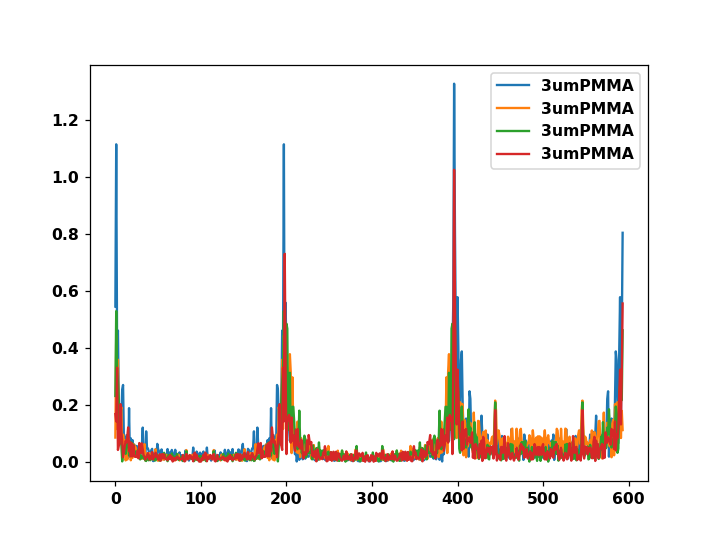

<IPython.core.display.Javascript object>


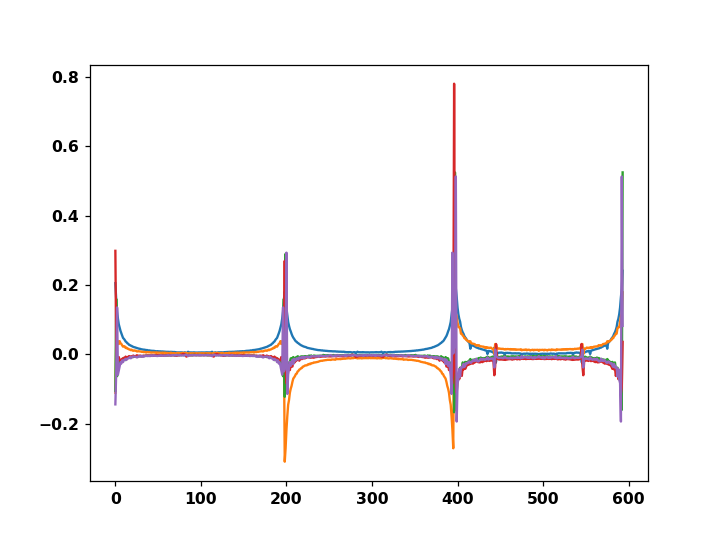

<IPython.core.display.Javascript object>


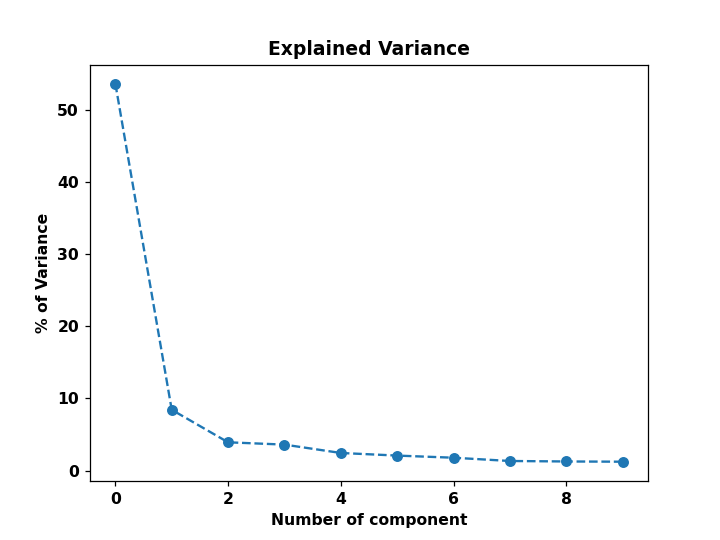

<IPython.core.display.Javascript object>


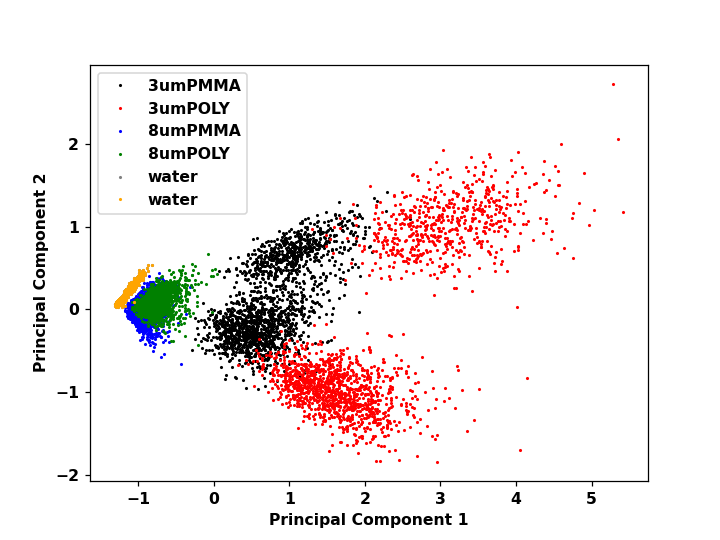

<IPython.core.display.Javascript object>


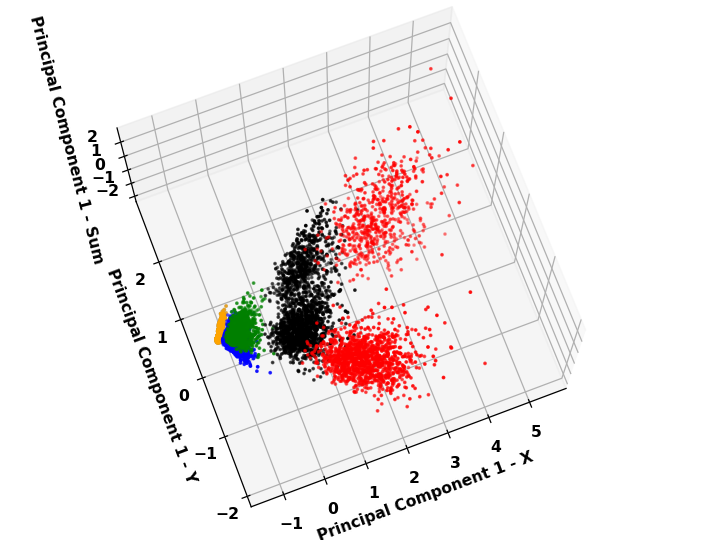

Text(0.5, 0, 'Principal Component 1 - Sum')

In [58]:
data_to_classify_train,labels_train, dummy_labels_train, unique_targets_train = data_classifier_concatenated(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
PCS= pca_data_concatenated(data_to_classify_train, ncomp=5)



%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train

#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(data_to_classify_test)
PCs1 = PCS
#print(PCs1.shape)

#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')

subplots()
unique_targets = unique_targets_train
labels = labels_train
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[4]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==4)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D

"""
fig = figure()
size=2
e_color=None
pc1 = 0
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')
"""

fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3 = 2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs1[i0,pc2], PCs1[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs1[i1,pc2], PCs1[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs1[i2,pc2], PCs1[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs1[i3,pc2], PCs1[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs1[i4,pc2], PCs1[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs1[i5,pc2], PCs1[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')

# FFT+PCA classifier

<IPython.core.display.Javascript object>


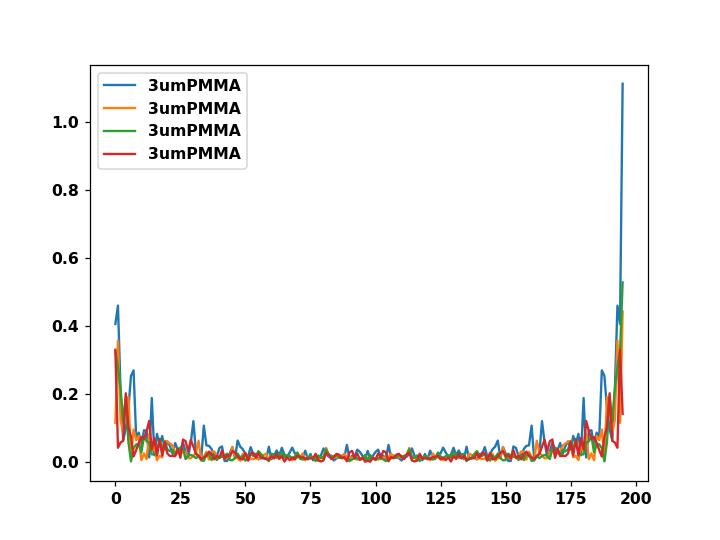

(9000, 10)


<IPython.core.display.Javascript object>


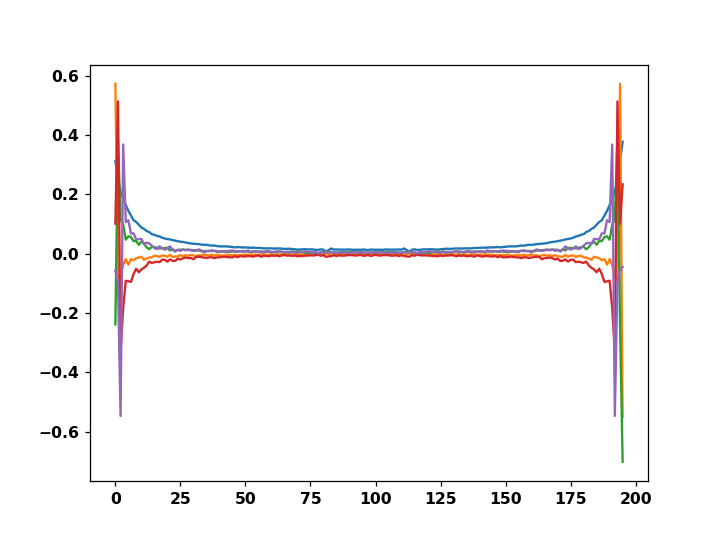

<IPython.core.display.Javascript object>


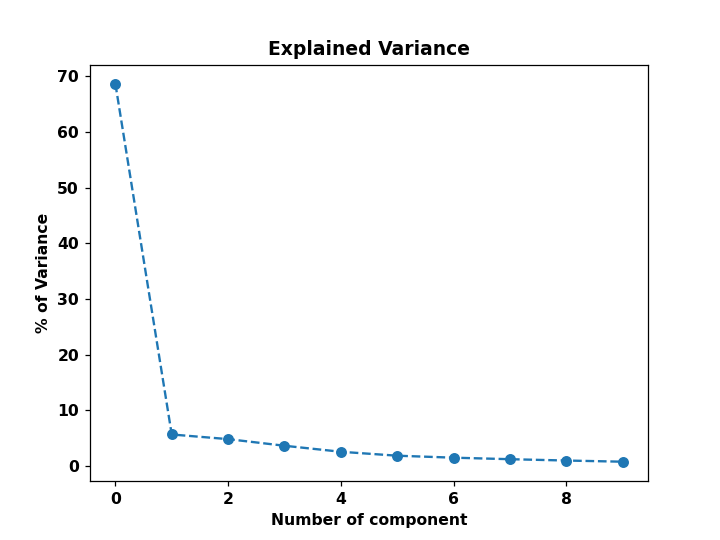

<IPython.core.display.Javascript object>


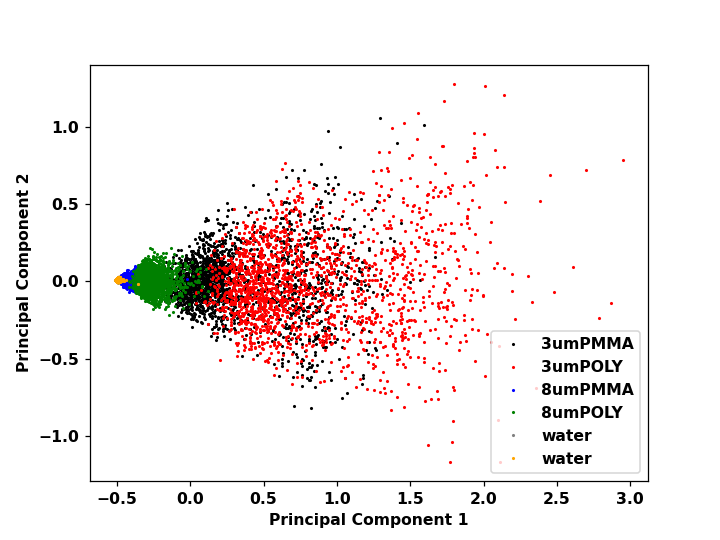

<IPython.core.display.Javascript object>


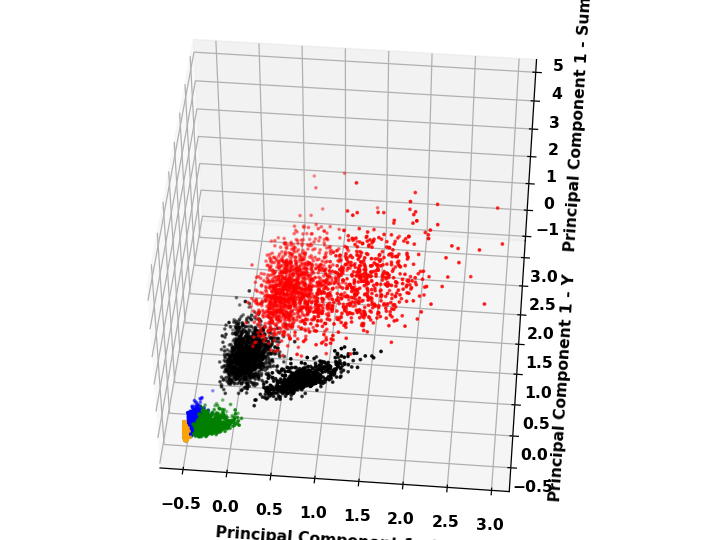

<IPython.core.display.Javascript object>


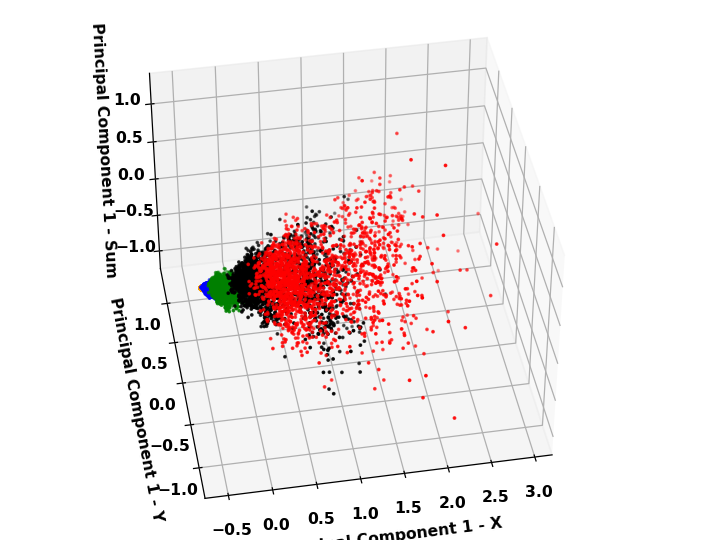

Text(0.5, 0, 'Principal Component 1 - Sum')

In [62]:
data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
PCS= pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=5)

data_to_classify_test, data_to_classify2_test, data_to_classify3_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)


%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train

#new_data_to_classify_train = np.concatenate([data_to_classify_train, data_to_classify2_train, data_to_classify3_train], axis=1)

#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(data_to_classify_train)
print(PCs1.shape)

#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')



model.fit(data_to_classify2_train)
PCs2 = model.transform(data_to_classify2_train)

model.fit(data_to_classify3_train)
PCs3 = model.transform(data_to_classify3_train)

subplots()
unique_targets = unique_targets_train
labels = labels_train
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[4]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==4)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D


fig = figure()
size=2
e_color=None
pc1 = 0
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')


fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3 = 2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs1[i0,pc2], PCs1[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs1[i1,pc2], PCs1[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs1[i2,pc2], PCs1[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs1[i3,pc2], PCs1[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs1[i4,pc2], PCs1[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs1[i5,pc2], PCs1[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')

<IPython.core.display.Javascript object>


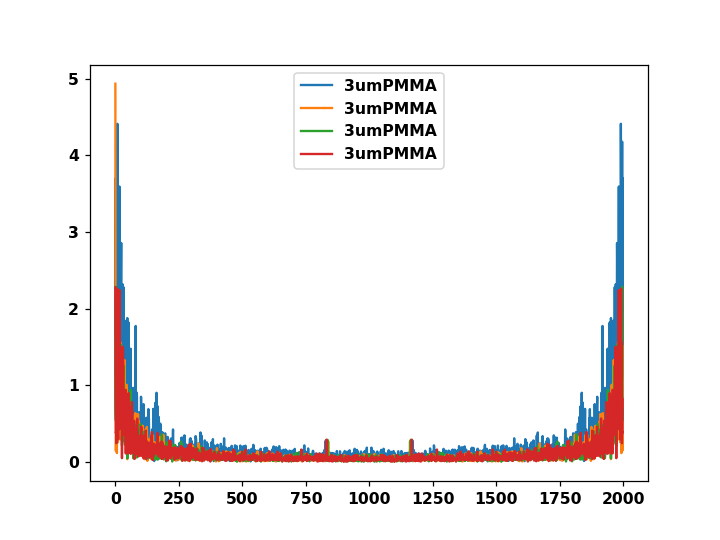

(9049, 10)


<IPython.core.display.Javascript object>


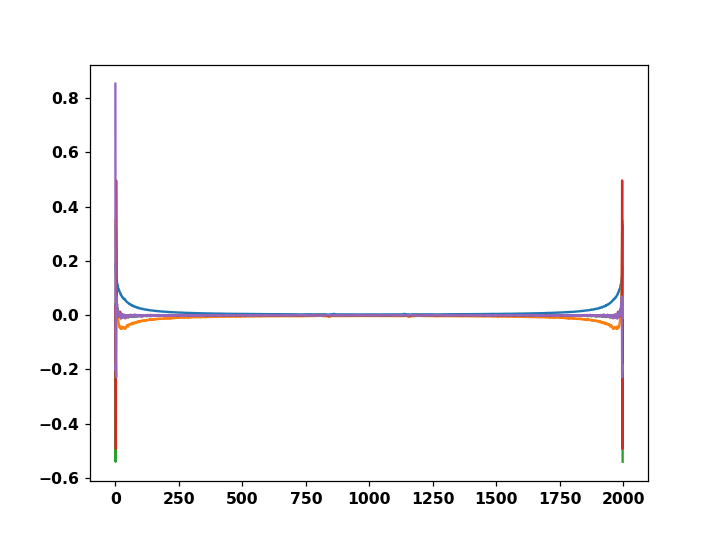

<IPython.core.display.Javascript object>


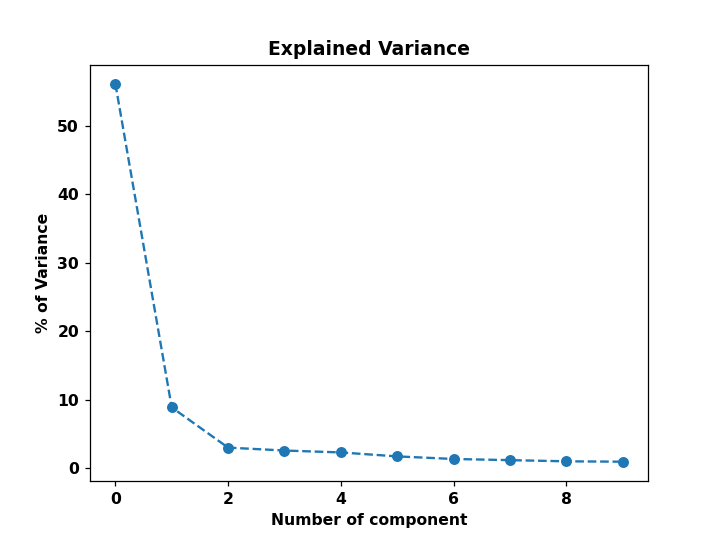

<IPython.core.display.Javascript object>


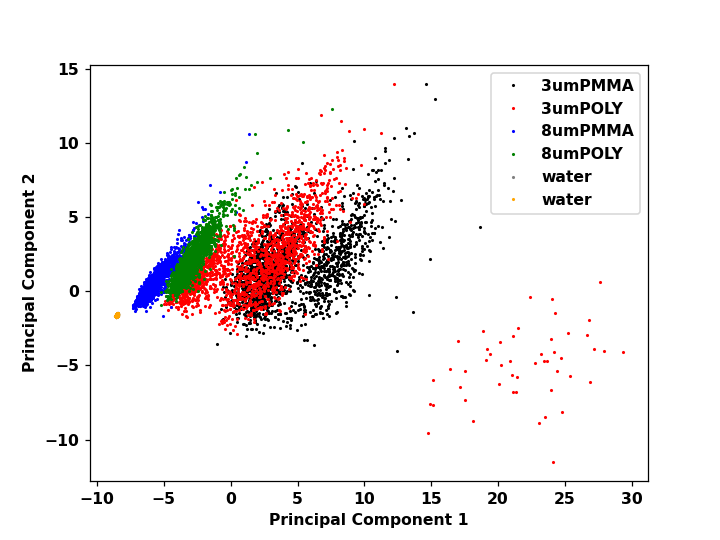

<IPython.core.display.Javascript object>


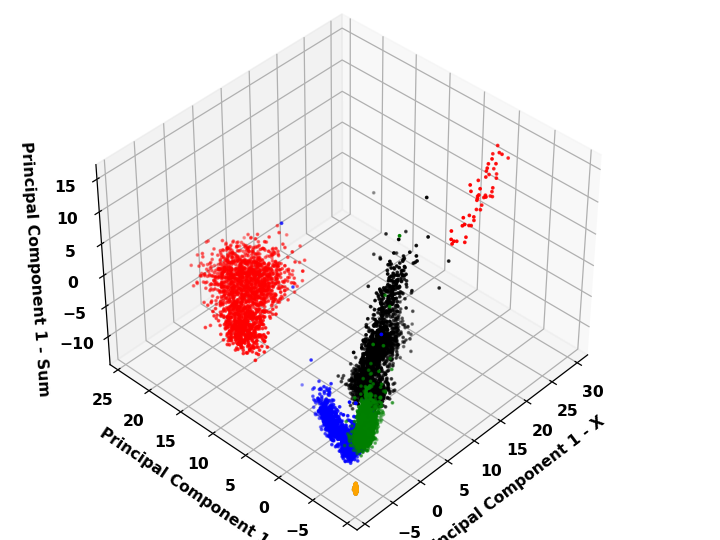

<IPython.core.display.Javascript object>


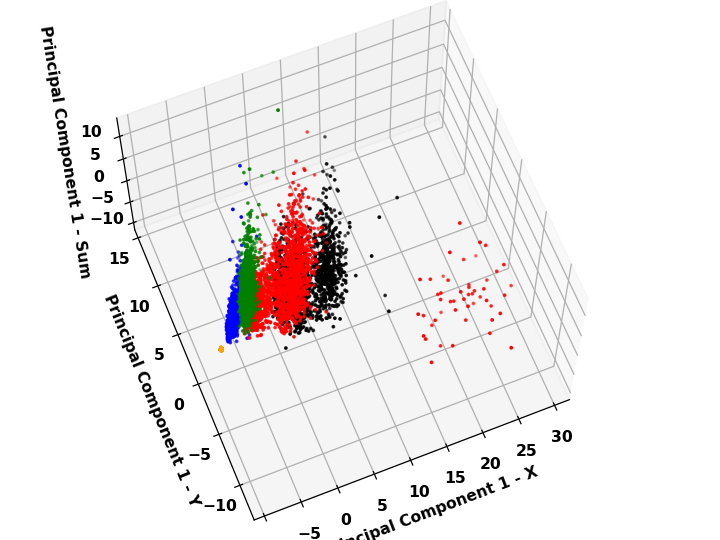

Text(0.5, 0, 'Principal Component 1 - Sum')

In [26]:
data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
PCS= pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=5)

data_to_classify_test, data_to_classify2_test, data_to_classify3_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)


%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train

#new_data_to_classify_train = np.concatenate([data_to_classify_train, data_to_classify2_train, data_to_classify3_train], axis=1)

#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(data_to_classify_test)
print(PCs1.shape)

#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')



model.fit(data_to_classify2_train)
PCs2 = model.transform(data_to_classify2_test)

model.fit(data_to_classify3_train)
PCs3 = model.transform(data_to_classify3_test)

subplots()
unique_targets = unique_targets_test
labels = labels_test
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[4]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==4)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D


fig = figure()
size=2
e_color=None
pc1 = 0
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')


fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3 = 2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs1[i0,pc2], PCs1[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs1[i1,pc2], PCs1[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs1[i2,pc2], PCs1[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs1[i3,pc2], PCs1[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs1[i4,pc2], PCs1[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs1[i5,pc2], PCs1[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')

In [ ]:
np.stack([new_data_to_classify_train,data_to_classify2_train], axis=2).shape

In [ ]:
tensorly.set_backend('tensorflow')
PCs1,error = tensorly.decomposition.robust_pca(np.stack([new_data_to_classify_train,data_to_classify2_train], axis=2))

In [ ]:
import tensorflow as tf
import tensorflow_transform as tft

PCs1 = tft.pca(np.stack([new_data_to_classify_train,data_to_classify2_train], axis=2))

# FFT + Tensor PCA

In [ ]:
import tensorly as tensorly

data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
PCS= pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=5)

%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train
#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

PCs1,error = tensorly.decomposition.robust_pca(np.concatenate([new_data_to_classify_train,new_data_to_classify2_train], axis=1))
#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')

subplots()
unique_targets = unique_targets_train
labels = labels_train
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D

fig = figure()
size=2
e_color=None
pc1 = 0
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')

# FFT Moving Average

In [ ]:
data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_moving_average(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train, N=5)
PCS= pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=5)

%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
#new_data_to_classify_train = data_to_classify_train
#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(new_data_to_classify_train)


#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')




model.fit(data_to_classify2_train)
PCs2 = model.transform(data_to_classify2_train)

model.fit(data_to_classify3_train)
PCs3 = model.transform(data_to_classify3_train)



subplots()
unique_targets = unique_targets_train
labels = labels_train
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D

fig = figure()
size=2
e_color=None
pc1 = 0
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1 - X")
ax.set_ylabel('Principal Component 1 - Y')
ax.set_zlabel('Principal Component 1 - Sum')

# Spectrogram classifier

In [ ]:
data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_spectrogram(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train, nperseg=200)
PCS= pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=5)

%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train
#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(new_data_to_classify_train)

#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')

subplots()
unique_targets = unique_targets_train
labels = labels_train
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

# Spectrogram Components Classifier

In [ ]:
data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_spectrogram(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train, nperseg=200)
PCS= pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=5)

%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train
#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()

model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(new_data_to_classify_train)
PCs1 = new_data_to_classify_train
PCs2 = data_to_classify2_train

#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
title('Explained Variance')
plot(100*model.explained_variance_ratio_,'o', ls='--')
xlabel('Number of component')
ylabel('% of Variance')

subplots()
unique_targets = unique_targets_train
labels = labels_train
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

ms=1
plot(PCs1[i0,pc1],PCs2[i0,pc1],'o', markersize=ms,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs2[i1,pc1],'o', markersize=ms,color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs2[i2,pc1],'o', markersize=ms,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs2[i3,pc1],'o', markersize=ms,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs2[i4,pc1],'o', markersize=ms,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs2[i5,pc1],'o', markersize=ms,color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

# 

In [ ]:
np.concatenate([Pcs1,Pcs1],axis=1).shape
Pcs1[:,1:].shape

In [ ]:
from scipy.signal import *

i1 = 2200
nsegments = 600

fs =100000

print(target_train[i1])
new_data_to_classify_train = y_data_train[int(i1/nsegments)]
sig = np.array(new_data_to_classify_train[1])
f,t,spectro1 = spectrogram(sig,fs=fs,nperseg = 200)
print(spectro1.shape)
subplots()
samplingFrequency = 60
subplot(211)
plot(sig)
subplot(212)
imshow(np.log10(spectro1), aspect = 'auto')
subplots()
plot(spectro1.mean(axis=1))

In [ ]:
from scipy.signal import *

i1 = 1200
nsegments = 100

fs =1000

print(target_train[i1])
new_data_to_classify_train = x_data_train[int(i1/nsegments)]
sig = np.array(new_data_to_classify_train[1])
f,t,spectro1 = spectrogram(sig,fs=fs)
print(spectro1.shape)
subplots()
samplingFrequency = 60
subplot(211)
plot(sig)
subplot(212)
imshow(np.log10(spectro1), aspect = 'auto')

i1 = 400
print(target_train[i1])
new_data_to_classify_train = x_data_train[int(i1/nsegments)]
sig = np.array(new_data_to_classify_train[1])
f,t,spectro = spectrogram(sig,fs=fs)
print(spectro.shape)
subplots()
samplingFrequency = 60
subplot(211)
plot(sig)
subplot(212)
imshow(np.log10(spectro), aspect = 'auto')
#powerSpectrum, freqenciesFound, time, imageAxis = specgram(sig, Fs=samplingFrequency)

subplots()
plot(spectro.mean(axis=1))
plot(spectro1.mean(axis=1))

i1 = 800
print(target_train[i1])
new_data_to_classify_train = x_data_train[int(i1/nsegments)]
sig = np.array(new_data_to_classify_train[1])
f,t,spectro2 = spectrogram(sig,fs=fs)
print(spectro2.shape)
subplots()
samplingFrequency = 60
subplot(211)
plot(sig)
subplot(212)
imshow(np.log10(spectro2), aspect = 'auto')
#powerSpectrum, freqenciesFound, time, imageAxis = specgram(sig, Fs=samplingFrequency)

subplots()
plot(spectro.mean(axis=1))
plot(spectro1.mean(axis=1))
plot(spectro2.mean(axis=1))



In [ ]:
i1
new_data_to_classify_train[0].shape

In [ ]:
N=3
i1=0
i2=1000
i3=600
i4=800
mv = pd.Series(new_data_to_classify_train[i1]).rolling(window=N).mean().iloc[N-1:].values
subplots()
plot(new_data_to_classify_train[i1])
plot(mv)

In [ ]:
%matplotlib notebook
subplots()
i1=0
i2=1000
i3=600
i4=800
new_data_to_classify_train = np.log10(np.abs(data_to_classify_train))
new_data_to_classify_train = data_to_classify_train
#scaler1 = preprocessing.StandardScaler()
#scaler1.fit(new_data_to_classify_train)
#new_data_to_classify_train  = scaler1.transform(new_data_to_classify_train)
plot(new_data_to_classify_train[i1],label=target_train[i1])
plot(new_data_to_classify_train[i2],label=target_train[i2])
plot(new_data_to_classify_train[i3],label=target_train[i3])
plot(new_data_to_classify_train[i4],label=target_train[i4])
legend()
model = decomposition.PCA(n_components = 10)
model.fit(new_data_to_classify_train)
PCs1 = model.transform(new_data_to_classify_train)
PCs1 = data_to_classify_train[:,0:2]
#print(model.explained_variance_ratio_)
subplots()
plot(model.components_[0])
plot(model.components_[1])
plot(model.components_[2])
plot(model.components_[3])
plot(model.components_[4])

subplots()
plot(model.explained_variance_ratio_)

# Test a model

D:data OT - TT//test//water6.dat Read 1200 segmentstss

(21698, 998)
(21600, 998)
KNeighborsClassifier(n_neighbors=30)
Score test
0.6944700460829493
Score test
0.6700460829493088
Score test
0.6870967741935484
Score test
0.6732718894009216
Score test
0.6682027649769585
Score test
0.6741935483870968
Score test
0.6755760368663595
Score test
0.6898617511520737
Score test
0.6852534562211982
Score test
0.6857142857142857


<IPython.core.display.Javascript object>


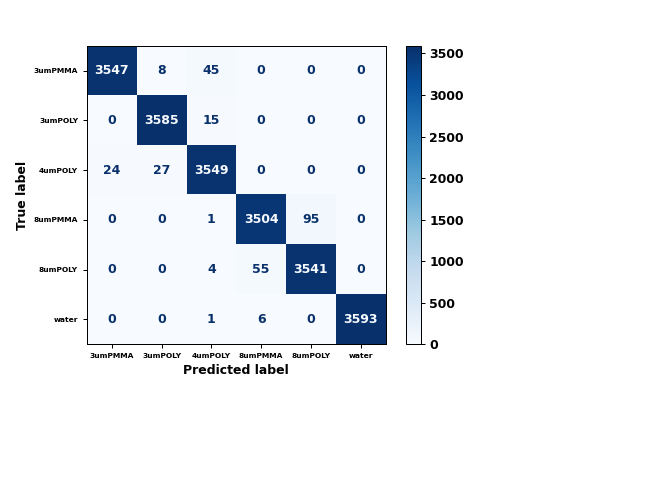

<IPython.core.display.Javascript object>


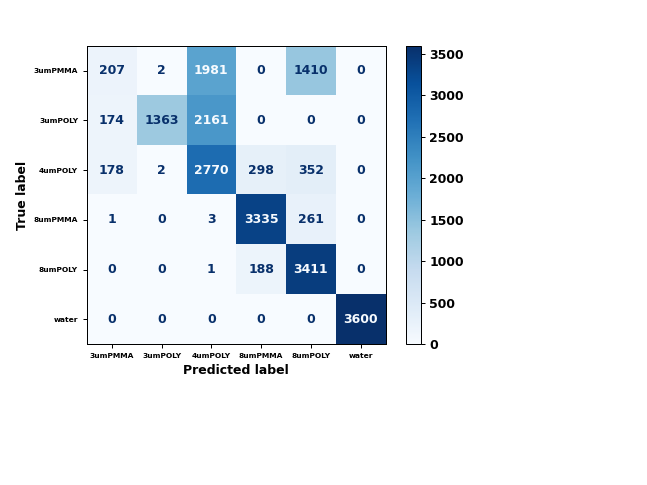

Model Accuracy -> 0.68036866359447


In [4]:
%matplotlib notebook
def test_a_model(model, npoints, folder_train, folder_test, confusion_matrix = False, ncomp = 3,nsegments = 200, scaler = False , use_only = False):

    target_train, x_data_train, y_data_train, sum_data_train = load_data(npoints, folder_train, nsegments=nsegments)
    data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
    


    PCs_train,pca_model = pca_data_new_model(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=ncomp, use_only = use_only)
    if scaler:
        scaler = preprocessing.StandardScaler()
        scaler.fit(PCs_train)
        PCs_train = scaler.transform(PCs_train)

    target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments=nsegments)
    
    data_to_classify_test, data_to_classify2_test, data_to_classify3_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)
    

    PCs_test = pca_data_previous_model(data_to_classify_test, data_to_classify2_test, data_to_classify3_test, pca_model, ncomp=ncomp, use_only = use_only)
    
    if scaler:
        PCs_test = scaler.transform(PCs_test)
 

    print('\n')
    print(data_to_classify_test.shape)
    print(data_to_classify_train.shape)
    print(model)
    
    scores=[]
    for rs in range(0,10):
        ts=0.1



        X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs_train, labels_train, test_size=ts, random_state=rs)
        trash1, X_test, trash2, y_test = model_selection.train_test_split(PCs_test, labels_test, test_size=ts, random_state=rs)

        model.fit(X_train,y_train)

        print('Score test')
        scr = model.score(X_test,y_test)
        print(model.score(X_test,y_test))
        scores.append(scr)
        
 
    if confusion_matrix:
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_train)
        conf_mat = metrics.confusion_matrix(labels_train, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_test)
        conf_mat = metrics.confusion_matrix(labels_test, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
        
    print("Model Accuracy -> " + str(np.mean(scores)))
    return scores

model = ensemble.RandomForestClassifier(n_estimators=100,random_state=0)
model = tree.DecisionTreeClassifier()
model = neighbors.KNeighborsClassifier(30)
#model = svm.SVC(kernel="linear", C=0.25)
#model = neural_network.MLPClassifier(activation = 'tanh')
#model = linear_model.LogisticRegression()
#model = naive_bayes.GaussianNB()
folder_train = "D:data OT - TT//train//"
folder_test = "D:data OT - TT//test//"
npoints = 1000
scores = test_a_model(model, npoints, folder_train, folder_test, True, ncomp=2, nsegments = 1200, scaler = False, use_only = False)

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\pandas\core\window\rolling.py:355: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\pandas\core\window\rolling.py:355: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)




(10849, 1993)
(10800, 1993)
RandomForestClassifier(random_state=0)
Score test
0.623963133640553
Score test
0.5990783410138248
Score test
0.6129032258064516
Score test
0.6156682027649769
Score test
0.6184331797235023
Score test
0.6276497695852534
Score test
0.6331797235023041
Score test
0.6497695852534562
Score test
0.6543778801843319
Score test
0.6534562211981567


<IPython.core.display.Javascript object>


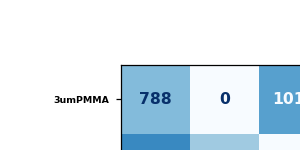

Model Accuracy -> 0.6288479262672811


In [15]:
def test_a_model_moving_average(model, npoints, folder_train, folder_test, confusion_matrix = False, ncomp = 3,nsegments = 200, scaler = False , use_only = False):

    target_train, x_data_train, y_data_train, sum_data_train = load_data(npoints, folder_train, nsegments=nsegments)
    data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_moving_average(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
    
    if scaler:
        scalers = get_scalers(data_to_classify_train, data_to_classify2_train, data_to_classify3_train)
        data_to_classify_train, data_to_classify2_train, data_to_classify3_train = scale(scalers,data_to_classify_train, 
                                                                                         data_to_classify2_train, data_to_classify3_train)
        
    PCs_train = pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=ncomp, use_only = use_only)
    
    target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments=nsegments)
    
    data_to_classify_test, data_to_classify2_test, data_to_classify3_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier_moving_average(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)
    
    if scaler:
        data_to_classify_test, data_to_classify2_test, data_to_classify3_test = scale(scalers,data_to_classify_test, 
                                                                                         data_to_classify2_test, data_to_classify3_test)
   
    
    PCs_test = pca_data(data_to_classify_test, data_to_classify2_test, data_to_classify3_test, ncomp=ncomp, use_only = use_only)
    
    print('\n')
    print(data_to_classify_test.shape)
    print(data_to_classify_train.shape)
    print(model)
    
    scores=[]
    for rs in range(0,10):
        ts=0.1



        X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs_train, labels_train, test_size=ts, random_state=rs)
        trash1, X_test, trash2, y_test = model_selection.train_test_split(PCs_test, labels_test, test_size=ts, random_state=rs)

        model.fit(X_train,y_train)

        print('Score test')
        scr = model.score(X_test,y_test)
        print(model.score(X_test,y_test))
        scores.append(scr)
        
 
    if confusion_matrix:
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_test)
        conf_mat = metrics.confusion_matrix(labels_test, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
    print("Model Accuracy -> " + str(np.mean(scores)))
    return scores

model = ensemble.RandomForestClassifier(n_estimators=100,random_state=0)
#model = tree.DecisionTreeClassifier()
#model = neighbors.KNeighborsClassifier(10)
#model = neural_network.MLPClassifier(activation = 'tanh')
#model = linear_model.LogisticRegression()
folder_train = "D:data OT - TT//train//"
folder_test = "D:data OT - TT//test//"
npoints = 2000
scores = test_a_model_moving_average(model, npoints, folder_train, folder_test, True, ncomp=2, nsegments = 600, scaler = False, use_only = True)

In [ ]:
def test_a_model_spectrogram(model, npoints, folder_train, folder_test, confusion_matrix = False, ncomp = 3,nsegments = 200, scaler = False , use_only = False):

    target_train, x_data_train, y_data_train, sum_data_train = load_data(npoints, folder_train, nsegments=nsegments)
    data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_spectrogram(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train,nperseg=200)
    
    if scaler:
        scalers = get_scalers(data_to_classify_train, data_to_classify2_train, data_to_classify3_train)
        data_to_classify_train, data_to_classify2_train, data_to_classify3_train = scale(scalers,data_to_classify_train, 
                                                                                         data_to_classify2_train, data_to_classify3_train)
        
    PCs_train = pca_data(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=ncomp, use_only = use_only)
    
    target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments=nsegments)
    
    data_to_classify_test, data_to_classify2_test, data_to_classify3_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier_spectrogram(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test,nperseg=200)
    
    if scaler:
        data_to_classify_test, data_to_classify2_test, data_to_classify3_test = scale(scalers,data_to_classify_test, 
                                                                                         data_to_classify2_test, data_to_classify3_test)
   
    
    PCs_test = pca_data(data_to_classify_test, data_to_classify2_test, data_to_classify3_test, ncomp=ncomp, use_only = use_only)
    
    print('\n')
    print(data_to_classify_test.shape)
    print(data_to_classify_train.shape)
    print(model)
    
    scores=[]
    for rs in range(0,10):
        ts=0.1



        X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs_train, labels_train, test_size=ts, random_state=rs)
        trash1, X_test, trash2, y_test = model_selection.train_test_split(PCs_test, labels_test, test_size=ts, random_state=rs)

        model.fit(X_train,y_train)

        print('Score test')
        scr = model.score(X_test,y_test)
        print(model.score(X_test,y_test))
        scores.append(scr)
        
 
    if confusion_matrix:
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_test)
        conf_mat = metrics.confusion_matrix(labels_test, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
    print("Model Accuracy -> " + str(np.mean(scores)))
    return scores

model = ensemble.RandomForestClassifier(n_estimators=100,random_state=0)
#model = tree.DecisionTreeClassifier()
#model = neighbors.KNeighborsClassifier(10)
#model = neural_network.MLPClassifier(activation = 'tanh')
#model = linear_model.LogisticRegression()
folder_train = "D:data OT - TT//train//"
folder_test = "D:data OT - TT//test//"
npoints = 2000
scores = test_a_model_spectrogram(model, npoints, folder_train, folder_test, True, ncomp=1, nsegments = 600, scaler = False, use_only = True)

# Concatenated approach

(13598, 3)- TT//train//water3.dat Read 753 segmentsts
(13598,)
D:data OT - TT//test//water6.dat Read 756 segmentsts

(13660, 5994)
(13598, 5994)
KNeighborsClassifier(n_neighbors=100)
Score test
0.5153733528550513
Score test
0.5051244509516838
Score test
0.5087847730600292
Score test
0.5190336749633968
Score test
0.49633967789165445
Score test
0.49633967789165445
Score test
0.5117130307467057
Score test
0.5146412884333821
Score test
0.5212298682284041
Score test
0.5161054172767203


<IPython.core.display.Javascript object>


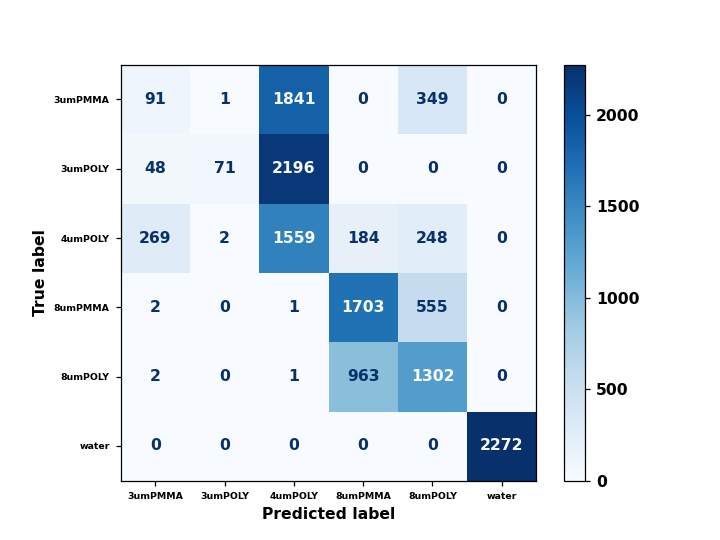

Model Accuracy -> 0.5104685212298682


In [92]:
def test_a_model_concatenated(model, npoints, folder_train, folder_test, confusion_matrix = False, ncomp = 3,nsegments = 200, scaler = False , use_only = False):

    target_train, x_data_train, y_data_train, sum_data_train = load_data(npoints, folder_train, nsegments=nsegments)
    data_to_classify_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier_concatenated(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
    
    
    
    if scaler:
        scalers = get_scalers(data_to_classify_train, data_to_classify2_train, data_to_classify3_train)
        data_to_classify_train, data_to_classify2_train, data_to_classify3_train = scale(scalers,data_to_classify_train, 
                                                                                         data_to_classify2_train, data_to_classify3_train)
        
    PCs_train,pca_model = pca_data_concatenated_new_model(data_to_classify_train, ncomp=ncomp, use_only = use_only)
    
    print(PCs_train.shape)
    print(labels_train.shape)
    
    target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments=nsegments)
    
    data_to_classify_test,  labels_test, dummy_labels_test, unique_targets_test = data_classifier_concatenated(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)
    
    if scaler:
        data_to_classify_test, data_to_classify2_test, data_to_classify3_test = scale(scalers,data_to_classify_test, 
                                                                                         data_to_classify2_test, data_to_classify3_test)
   
    
    PCs_test = pca_data_concatenated_previous_model(data_to_classify_test,pca_model, ncomp=ncomp, use_only = use_only)
    
    print('\n')
    print(data_to_classify_test.shape)
    print(data_to_classify_train.shape)
    print(model)
    
    scores=[]
    for rs in range(0,10):
        ts=0.1



        X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs_train, labels_train, test_size=ts, random_state=rs)
        trash1, X_test, trash2, y_test = model_selection.train_test_split(PCs_test, labels_test, test_size=ts, random_state=rs)

        model.fit(X_train,y_train)

        print('Score test')
        scr = model.score(X_test,y_test)
        print(model.score(X_test,y_test))
        scores.append(scr)
        
 
    if confusion_matrix:
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_test)
        conf_mat = metrics.confusion_matrix(labels_test, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
    print("Model Accuracy -> " + str(np.mean(scores)))
    return scores

model = ensemble.RandomForestClassifier(n_estimators=100,random_state=0)
#model = tree.DecisionTreeClassifier()
model = neighbors.KNeighborsClassifier(100)
#model = neural_network.MLPClassifier(activation = 'tanh')
#model = linear_model.LogisticRegression()
folder_train = "D:data OT - TT//train//"
folder_test = "D:data OT - TT//test//"
npoints = 2000
scores = test_a_model_concatenated(model, npoints, folder_train, folder_test, True, ncomp=3, nsegments = 1200, scaler = False, use_only = False)

In [ ]:
model.n_classes_

In [ ]:
model = ensemble.RandomForestClassifier(n_estimators=1)
#model = linear_model.RidgeClassifier()
npoints = 200
scores = test_a_model(model, npoints, True)

In [ ]:
#model = cross_decomposition.PLSRegression().fit(X=data_to_classify,Y=dummy_labels)
#model = discriminant_analysis.LinearDiscriminantAnalysis()
#model = linear_model.LogisticRegression()
#model = svm.SVC()
npoints_list=[5,20,100,200,500,1000,2000]

scores_min =[]
scores_max =[]
scores_mean =[]

model = ensemble.RandomForestClassifier(n_estimators=60)

for npoints in npoints_list:    
    scores = test_a_model(model, npoints, True)
    scores_min.append(min(scores))
    scores_max.append(max(scores))
    scores_mean.append(np.mean(scores))

subplots()
title("Scores for RandomForestClassifier")
plot(npoints_list, scores_mean, ls='--', marker='o', color='k', lw=0.5)
fill_between(npoints_list, scores_min, scores_max,color='grey')


In [ ]:
subplots()
title("Scores for RandomForestClassifier")
plot(npoints_list, scores_mean, ls='--', marker='o', color='k', lw=0.5)
fill_between(npoints_list, scores_min, scores_max,color='grey', alpha=0.1)


## Plot acquired data

In [ ]:
%matplotlib notebook
#import matplotlib.pyplot as plt

#In suptitle the name is defined by target which varies from 0 to 59 for each type file. And so, index 1 is defined for 
#3umPMMA from 0 to 59, and so, to be adjusted to each file in t_data which varies from t_data[0] to t_data[35], and so 
#it must be divided  by number of slipts, so that from 0 to 59, the int(index1/splits) is related to file 0, 3umPMMA

#index 1 varies from 0 to 2160
index1 = 2
#graph aspect and respective axis labels
figure(figsize=[8,6])
subplot(211)
ax1=gca() #to get the axis
#axis labels
ax1.set_xlabel(r"$t (s)$")
ax1.set_ylabel(r"$X (V)$")
subplot(212)
ax2=gca() #to get the axis
#axis labels
ax2.set_xlabel(r"$f (Hz)$")
ax2.set_ylabel(r"$FFT - arb.un.$")
#log scale 
ax2.set_yscale('log')
ax2.set_xscale('log')
 
#inverse of the sample spacing(seconds) dt

dt=1E-4
total_time=npoints*dt

print(len(xx))

time=np.arange(0,total_time,dt)
#x=np.arange(0,1200000)*dt
#print(x)

splits=int(len(xx)/npoints)
for chunk in range(0, splits):    
    #title name
    #target varies from 0 to 59 for the first file, that is index1=1
    suptitle("Acquired data for " + target[index1])
    
    time_int=npoints*dt*chunk+time
    ax1.plot(time_int,x_data[int(index1/splits)][chunk],label="Split "+str(chunk))
    
    data_to_fft = x_data[index1][chunk]
    fft_data = np.fft.fft(data_to_fft)
    fft_data = np.fft.fftshift(fft_data)
    fft_freq = np.fft.fftfreq(len(fft_data),dt)
    fft_freq = np.fft.fftshift(fft_freq)
    
    plot(fft_freq,abs(fft_data) ,label="Split "+str(chunk))

print("Total time used for this measurement", total_time, "seconds")
print("Total number of files acquired is", (int(len(xx)/npoints)), "files")
print((time))
print(len(x_data[0][0]))
print(len(time_int))
print(int(index1/splits))
print(x_data[0][0])
print(len(x_data[0][0]))

# Classify data
Prepare the data, based on the FFT of each chunk

In [ ]:
data_to_classify = []
data_to_classify2 = []
data_to_classify3 = []
for i in range(0,len(x_data)):
    for j in range(0,len(x_data[i])):
        data_to_classify.append(np.abs(np.fft.fft(x_data[i][j])))
        data_to_classify2.append(np.abs(np.fft.fft(y_data[i][j])))
        data_to_classify3.append(np.abs(np.fft.fft(sum_data[i][j])))

data_to_classify=np.array(data_to_classify)
data_to_classify2=np.array(data_to_classify2)
data_to_classify3=np.array(data_to_classify3)

dummy_labels = []
labels = []
unique_targets = np.unique(target)
for i in range(0,len(target)):
    arr = np.zeros(len(unique_targets))
    labels.append(np.where(target[i]==unique_targets)[0][0])
    index = np.where(target[i]==unique_targets)[0][0]
    arr[index] = 1 
    dummy_labels.append(arr)

labels=np.array(labels)
dummy_labels = np.array(dummy_labels)
print(dummy_labels)

## PCA Analysis
Decompose the data based on principal components, and represent only the Principal component analysis of data_to_classify, corresponding to the x_data

In [ ]:
from sklearn import *

ncomp=3

model = decomposition.PCA(n_components=ncomp)
model.fit(data_to_classify)
PCs1 = model.transform(data_to_classify)

model.fit(data_to_classify2)
PCs2 = model.transform(data_to_classify2)

model.fit(data_to_classify3)
PCs3 = model.transform(data_to_classify3)


subplots()
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 1
pc2 = 2
c=['k','r','b','g','gray','orange']


plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'o',color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'o',color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o',color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'o',color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'o',color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

from mpl_toolkits.mplot3d import Axes3D
size=1
e_color=None
pc3=0
fig = figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs1[i0,pc2], PCs1[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs1[i1,pc2], PCs1[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs1[i2,pc2], PCs1[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs1[i3,pc2], PCs1[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs1[i4,pc2], PCs1[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs1[i5,pc2], PCs1[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

fig = figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs2[i0,pc1], PCs2[i0,pc2], PCs2[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs2[i1,pc1], PCs2[i1,pc2], PCs2[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs2[i2,pc1], PCs2[i2,pc2], PCs2[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs2[i3,pc1], PCs2[i3,pc2], PCs2[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs2[i4,pc1], PCs2[i4,pc2], PCs2[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs2[i5,pc1], PCs2[i5,pc2], PCs2[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3=2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs3[i0,pc1], PCs3[i0,pc2], PCs3[i0,pc3], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs3[i1,pc1], PCs3[i1,pc2], PCs3[i1,pc3], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs3[i2,pc1], PCs3[i2,pc2], PCs3[i2,pc3], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs3[i3,pc1], PCs3[i3,pc2], PCs3[i3,pc3], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs3[i4,pc1], PCs3[i4,pc2], PCs3[i4,pc3], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs3[i5,pc1], PCs3[i5,pc2], PCs3[i5,pc3], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

fig = figure()
size=2
e_color=None
pc1 = 0
pc2 = 1
pc3=2
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(PCs1[i0,pc1], PCs2[i0,pc1], PCs3[i0,pc1], color=c[0],edgecolor=e_color,s=size)
ax.scatter(PCs1[i1,pc1], PCs2[i1,pc1], PCs3[i1,pc1], color=c[1],edgecolor=e_color,s=size)
ax.scatter(PCs1[i2,pc1], PCs2[i2,pc1], PCs3[i2,pc1], color=c[2],edgecolor=e_color,s=size)
ax.scatter(PCs1[i3,pc1], PCs2[i3,pc1], PCs3[i3,pc1], color=c[3],edgecolor=e_color,s=size)
ax.scatter(PCs1[i4,pc1], PCs2[i4,pc1], PCs3[i4,pc1], color=c[4],edgecolor=e_color,s=size)
ax.scatter(PCs1[i5,pc1], PCs2[i5,pc1], PCs3[i5,pc1], color=c[5],edgecolor=e_color,s=size)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

In [ ]:
subplots()
plot(model.components_[2])

# Classifier based on PCA

In [ ]:
from sklearn import *

ts=0.2
rs=30

X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs, labels, test_size=ts, random_state=rs)

#model = cross_decomposition.PLSRegression().fit(X=data_to_classify,Y=dummy_labels)
#model = discriminant_analysis.LinearDiscriminantAnalysis()
#model = linear_model.LogisticRegression()
#model = svm.SVC()
model = ensemble.RandomForestClassifier(n_estimators=60)
model.fit(X_train,y_train)

print('Score test')
print(model.score(X_test,y_test))

# Scoring the model

In [ ]:
#Crossvalidation score
ts=0.2
rs=0
nfolds=30

cv = model_selection.ShuffleSplit(n_splits=nfolds, test_size=ts, random_state=rs)
scores = model_selection.cross_val_score(model, PCs, labels, cv=cv)
print("Model Accuracy -> " + str(np.mean(scores)))

#Generate a confusion matrix
labels_pred = model_selection.cross_val_predict(model, PCs, labels, cv=5)
conf_mat = metrics.confusion_matrix(labels, labels_pred,normalize="true")
metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets).plot(cmap=cm.Blues)
yticks(fontsize=6)
xticks(fontsize=6)